# AttGAN

## Introduzione

AttGAN (Attribute Generating Adversarial Networks) è una rete neurale generativa proposta in [Ha et al., 2018](https://arxiv.org/pdf/1711.10678.pdf), utilizzata per modificare caratteristiche specifiche delle immagini di volti (editing di attributi facciali). Ad esempio, può essere utilizzata per cambiare il colore dei capelli o la forma del viso di una persona in un'immagine. AttGAN utilizza il deep learning per analizzare un'immagine e riconoscere i tratti distintivi della persona, come il colore dei capelli, il tipo di pelle, la forma del viso, etc. Una volta identificati i tratti distintivi, AttGAN può modificare queste caratteristiche in modo coerente e realistico, creando un'immagine modificata realistica.Come si evince dal nome, la tecnica utilizza una GAN (Generative Adversarial Network), per cui vale la pena ripassare tale architettura. 


![example](https://raw.githubusercontent.com/LynnHo/AttGAN-Tensorflow/master/pics/slide.png)

## Introduzione alle GAN 

Denotiamo con $p_{data}(x)$ la distribuzione delle immagini reali $x$, e con $p_z(z)$ la distribuzione di input. La GAN è un modello generativo che permette di apprendere un generatore $G(z)$ che catturi la distribuzione $p_{data}$ attraverso un processo di apprendimento avversario (adversarial process). Viene introdotto un discriminatore $D$ il cui obiettivo è quello di distinguere le immagini reali $x \sim p_{data}$ da quelle generate dal generatore $G(z)$. A questo punto, il processo di apprendimento è formulato come un gioco minimax: 

$$
\min_G \max_D 
\mathbb{E}_{x \sim p_{data}}[ \log D(x) ] +
\mathbb{E}_{z \sim p_{z}}[ \log (1 - D(G(z)) ]
$$

Teoricamente, quando il processo raggiunge un equilibrio di Nash, il gioco minimax raggiunge un ottimo globale. 

## Formulazione della AttGAN

Sia $x^a$ un immagine con gli attributi binari $a = [a_1, \dots, a_n]$ dove $a_i$ indica un certo attributo (e.g. barba, colore dei capelli, etc.). Sia $G_{enc}$ l'encoder che ha lo scopo di mappare $x^a$ in una rappresentazione latente 

$$
z = G_{enc}(x^a)
$$ 

Supponiamo di voler cambiare gli attributi binari di $x^a$ in $b = [b_1, \dots, b_n]$, quindi usiamo la componente decoder $G_{dec}$ passandogli sia la rappresentazione latente $z$ che i nuovi attributi $b$, ed otteniamo l'immagine modificata: 

$$
x^{\hat{b}} = G_{dec}(z, b)
$$

In generale, il processo di generazione di un'immagine i quali attributi sono modificati da $a$ a $b$ è descritto dalla seguente equazione: 

$$
x^{\hat{b}} = G_{dec}(G_{enc}(x^a), b)
$$

## Training della GAN

Per assicurarci che l'immagine $x^{\hat b}$ contenga gli attributi specificati in $b$, essa viene classificata da un classificatore di attributi $C$. Per assicurarci che la struttura e i dettagli dell'immagine $x^a$ non vengano persi durante la generazione degli attributi, si adottano tecniche di reconstruction learning, ovvero il decoder $G_{dec}$ deve essere in grado di ottenere un'immagine idealmente uguale a quella di input $x^a$ quando prende in input la sua rappresentazione latente $z$ ed il suo vettore di attributi originale $a$, per cui si vincola il learning con la seguente regola: 

$$
x^{\hat a} = G_{dec}(z, a) \approx x^{a}
$$

La objective function finale è composta da tre componenti principali: 

+ La attribute classification loss
+ La reconstruction loss
+ L'adversarial loss


### Attribute classification loss

Per imporre il vincolo della presenza degli attributi specificati con il vettore binario $b = [b_1, \dots, b_n]$ utilizziamo la seguente loss function:  

$$
\min_{G_{enc}, G_{dec}} \mathcal{L_{cls_g}} = 
\mathbb{E}_{x^a \sim p_{data}, b \sim p_{attr}}[ l_g(x^a, b) ]
$$

Dove $p_{attr}$ è la distribuzione degli attributi. Con $l_g$ indichiamo la somma delle singole binary cross entropy loss su tutti gli attributi. Più semplicemente, sia $\hat{b} = C(x^{\hat{b}})$ il vettore binario degli attributi predetti dal classificatore rispetto all'immagine $x^{\hat b}$ generata dal generatore, allora possiamo usare $b$ come ground truth su ognuno degli attributi e quindi calcolare su ogni singolo attributo la binary cross entropy loss come segue:  

$$
l_g(x^a, b) = \sum_{i=1}^n -b_i\log \hat b_i - (1 - b_i) \log (1 - \hat b_i)
$$

Il classificatore $C$ è un classificatore multilabel (un'immagine può avere più attributi) ed è allenato in maniera supervised, utilizzando i dati $(x^a, a)$. La loss è molto simile alla precedente, ma viene ottimizzata rispetto ai parametri di $C$: 

$$
\min_{C} \mathcal{L_{cls_g}} = 
\mathbb{E}_{x^a \sim p_{data}}[ l_r(x^a, a) ]
$$

Dove $l_r$ è essenzialmente analoga ad $l_g$, ovvero la somma delle binary cross entropy loss. 

### Reconstruction loss

La reconstruction loss è molto intuitiva, ed è la norma $l_1$ della differenza tra l'immagine di input $x^a$ e l'immagine ricostruita $x^{\hat a} = G_{dec}(z, a)$: 

$$
\min_{G_{enc}, G_{dec}} \mathcal{L_{rec}} = 
\mathbb{E}_{x^a \sim p_{data}}[ \lVert x^a - x^{\hat a} \rVert_1 ]
$$

### Adversarial loss

Sia $D$ il discriminatore la cui funzione è quella di distinguere le immagini reali da quelle generate dal generatore. L'adversarial loss per il discriminatore è la seguente: 

$$
\min_{\lVert D \rVert_L \le 1} \mathcal{L_{adv_d}} = 
- \mathbb{E}_{x^a \sim p_{data}} D(x^a) + 
\mathbb{E}_{x^a \sim p_{data}, b \sim p_{attr}} D(x^{\hat{b}})
$$

Mentre l'adversarial loss per il generatore è la seguente: 

$$
\min_{G_{enc},G_{dec}} \mathcal{L_{adv_g}} = 
- \mathbb{E}_{x^a \sim p_{data}, b \sim p_{attr}} D(x^{\hat{b}})
$$

Le adversarial loss sono ottimizzate attraverso [WGAN-GP](https://paperswithcode.com/method/wgan-gp).

### Objective function finale

Combinando la attribute classification loss, la reconstruction loss e l'adversarial loss opportunamente pesate, otteniamo la seguente objective function: 

$$
\min_{G_{enc}, G_{dec}} \mathcal{L_{enc, dec}} = 
\lambda_1 \mathcal{L_{rec}} +
\lambda_2 \mathcal{L_{cls_g}} +
\mathcal{L_{adv_g}} 
$$

Il discriminatore $D$ e l'attribute classifier $C$ condividono molti layer, e vengono ottimizzati combinando l'adversarial loss e la classification loss come segue: 

$$
\min_{D, C} \mathcal{L_{dis, cls}} = 
\lambda_3 \mathcal{L_{cls_c}} +
\mathcal{L_{adv_d}} 
$$

I vari $\lambda$ sono iperparametri che servono a bilanciare le loss. 

### Attribute style

Gli autori della AttGAN permettono di generare vari livelli di un certo attributo, anziché utilizzare delle variabili binarie che determinano se l'attributo è presente o meno. Per fare ciò, introducono dei controllori $[\theta_1, \dots, \theta_n]$ dove $\theta_i$ controlla l'$i$-esimo attributo. Questo si ottiene andando a massimizzare la mutua informazione tra i controllori e le immagini di input. 

![attgan scheme](https://www.researchgate.net/publication/363208842/figure/fig1/AS:11431281082627251@1662088448616/AttGAN-architecture-HZK-19.ppm)

## Hands on!

Abbiamo scaricato l'[implementazione in PyTorch](https://github.com/elvisyjlin/AttGAN-PyTorch) di AttGAN e, modificando un po' la codebase, proviamo a generare qualche immagine. 

All'interno della cartella output sono presenti i parametri pre-allenati della rete, insieme ai vari settings con cui è stato eseguito l'esperimento. Carichiamo i settings da passare alla classe del modello:

In [1]:
import os
import json
import argparse
import warnings

warnings.filterwarnings('ignore')

class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
    def __contains__(self, item):
        return item in self.__dict__

EXP_DIR = './output/384_shortcut1_inject1_none_hq/'

with open(os.path.join(EXP_DIR, 'setting.txt')) as settings:
    settings = json.load(settings)
    
settings = Args(**settings)
settings.experiment_name

'384_shortcut1_inject1_none_hq'

Creiamo un'istanza di AttGAN:

In [2]:
from attganlib.attgan import AttGAN

attgan = AttGAN(settings)

Carichiamo i parametri preallenati:

In [3]:
weights_path = os.path.join(EXP_DIR, 'checkpoint', 'weights.149.pth')

attgan.load(weights_path)
attgan.eval()

Il modello è pronto per essere utilizzato! Carichiamo il dataset custom creato dagli autori del progetto, contenente alcune immagini di prova: 

In [4]:
from torch.utils.data import DataLoader
from attganlib.data import Custom

dataset = Custom(data_path='attganlib/data/custom/', 
                 attr_path='attganlib/data/list_attr_custom.txt',
                 image_size=settings.img_size,
                 selected_attrs=settings.attrs)

dataloader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=False, drop_last=False)

Le seguenti funzioni serviranno a generare e visualizzare le immagini.

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import utils as vutils
from attganlib.data import check_attribute_conflict
    
def generate_edited_images(img_a, att_a):
    att_b_list = [att_a]

    for i in range(settings.n_attrs):
        tmp = att_a.clone()
        tmp[:, i] = 1 - tmp[:, i]
        tmp = check_attribute_conflict(tmp, settings.attrs[i], settings.attrs)
        att_b_list.append(tmp)

    with torch.no_grad():
        samples = [img_a]
        for i, att_b in enumerate(att_b_list):
            att_b_ = (att_b * 2 - 1) * settings.thres_int
            if i > 0:
                att_b_[..., i - 1] = att_b_[..., i - 1] * settings.test_int / settings.thres_int
            samples.append(attgan.G(img_a, att_b_))

    return samples


def cast_to_image(tensor):
    arr = tensor.squeeze().numpy()
    im = (255 * (arr - arr.min()) / (arr.max() - arr.min())).astype(np.uint8)
    im = np.moveaxis(im, 0, -1)
    return Image.fromarray(im, mode='RGB')
    

def plot_results(samples):
    LABELS = ['Normal', 'Reconstruction'] +  settings.attrs
    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
    ax = ax.flatten()
    for i in range(15):
        im = cast_to_image( samples[i] )
        ax[i].set_axis_off()
        ax[i].imshow(im)
        ax[i].title.set_text(LABELS[i])
    plt.show()

Proviamo con la prima immagine del dataset:

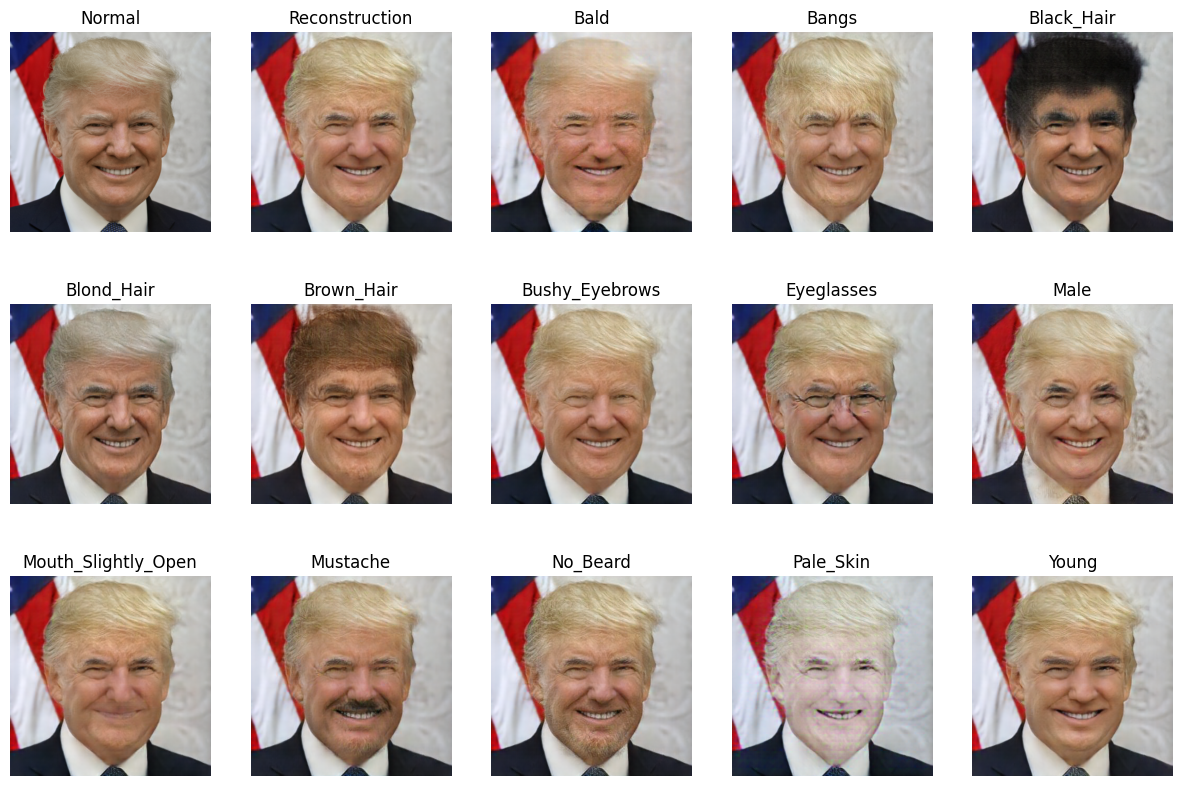

In [6]:
for img_a, att_a in dataloader: break
    
samples = generate_edited_images(img_a, att_a)

plot_results(samples)

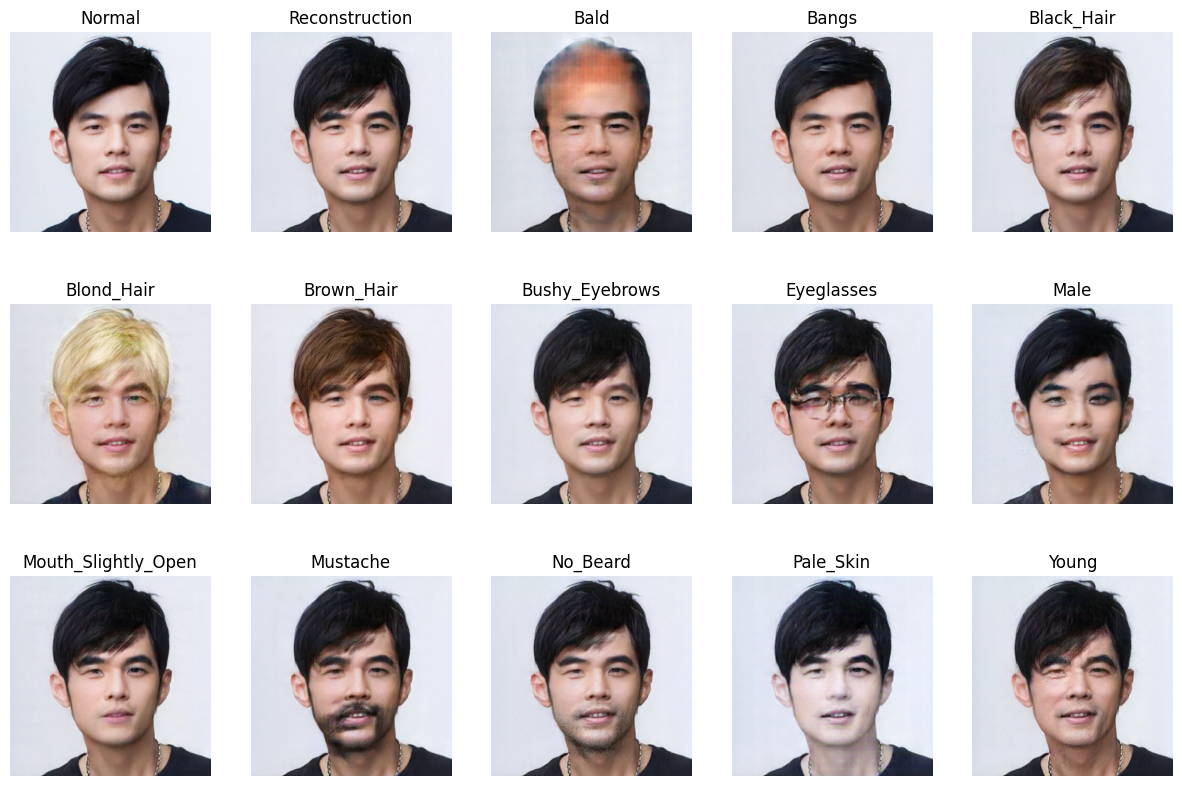

In [7]:
img_a, att_a = dataset[2]
img_a = img_a.unsqueeze(0)
att_a = att_a.unsqueeze(0)

samples = generate_edited_images(img_a, att_a)

plot_results(samples)

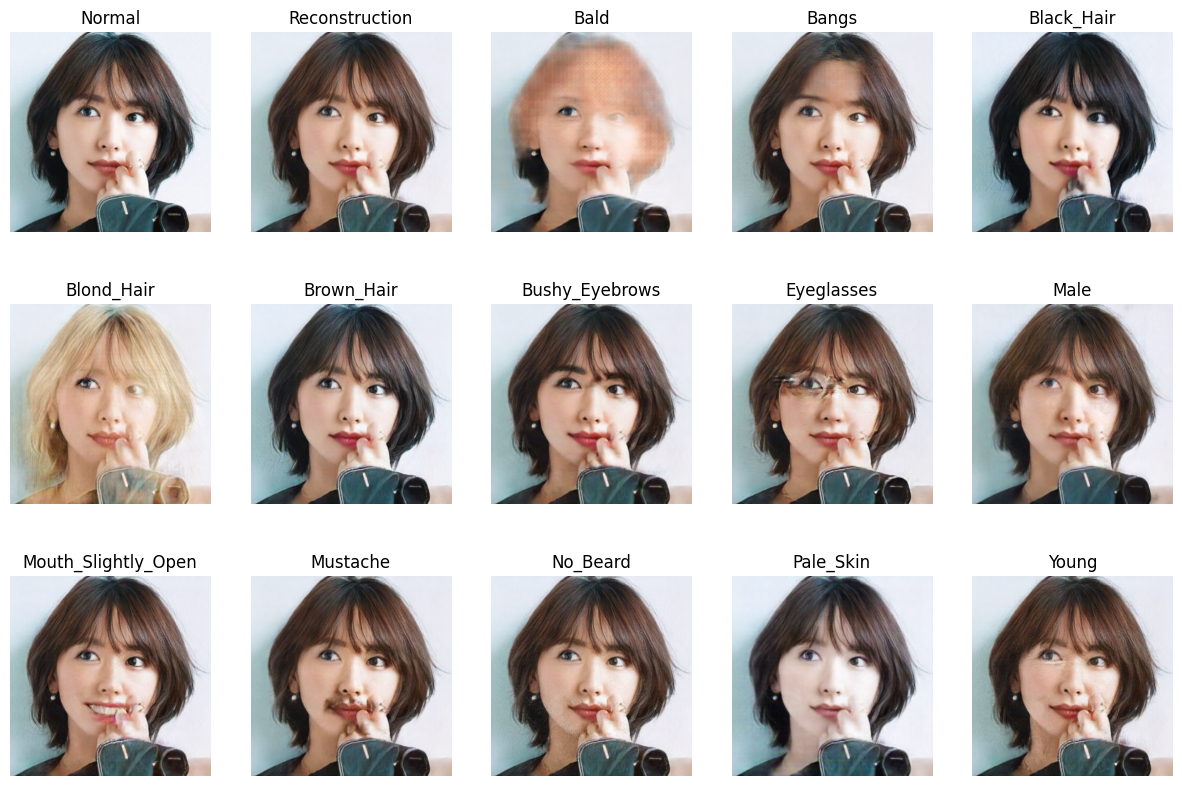

In [8]:
img_a, att_a = dataset[5]
img_a = img_a.unsqueeze(0)
att_a = att_a.unsqueeze(0)

samples = generate_edited_images(img_a, att_a)

plot_results(samples)

Proviamo con immagini scattate al volo:

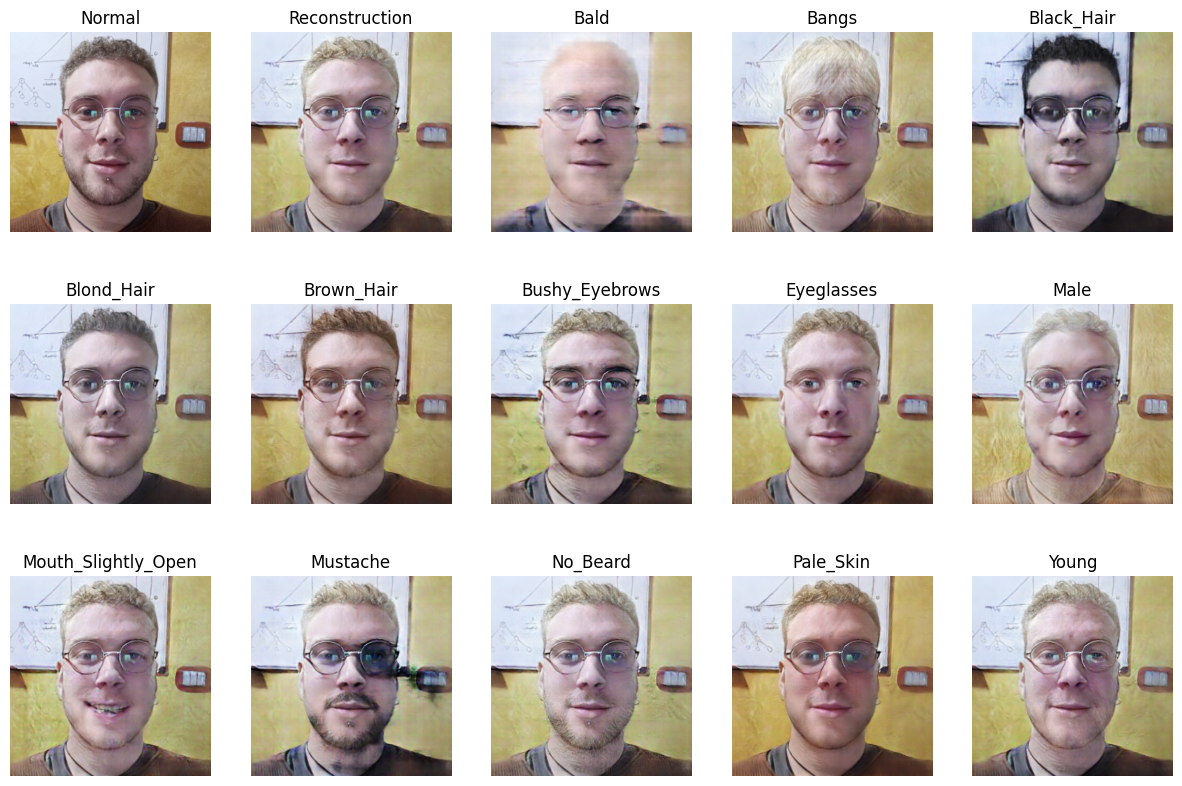

In [9]:
img_a, att_a = dataset[-2] # Lemuel
img_a = img_a.unsqueeze(0)
att_a = att_a.unsqueeze(0)

samples = generate_edited_images(img_a, att_a)

plot_results(samples)

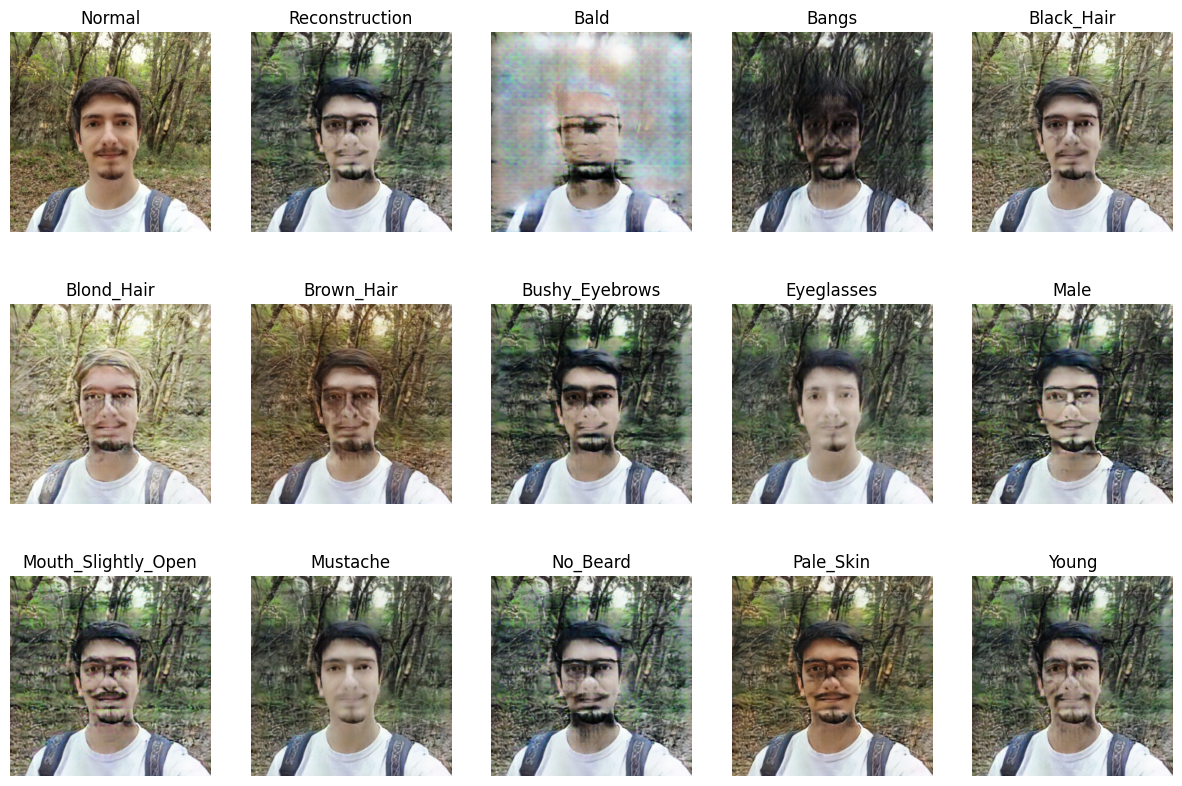

In [10]:
img_a, att_a = dataset[-1] # Luca
img_a = img_a.unsqueeze(0)
att_a = att_a.unsqueeze(0)

samples = generate_edited_images(img_a, att_a)

plot_results(samples)

(sembra che Luca non piaccia molto ad AttGAN)

## Conclusione

Gli autori della libreria PyTorch mettono a disposizione versioni pre-trained della GAN, tra cui quella utilizzata precedentemente. I risultati poco accurati sulle immagini esterne al dataset potrebbero essere causate dalla scarsa variabilità all'interno del dataset stesso. La metodologia è utilizzata con attributi facciali, ma ciò non toglie che tale tecnica possa essere utilizzata per task totalmente differenti, per controllare in generale la presenza di specifici attributi. 

## Authors

- Lemuel Puglisi
- Luca Garro